Lab #4 ,
Arend Matthew, aw3146

1. Run a simple regression, with at least two Xs in it, and interpret your results. (Did the results fit your expectations? Why? Why not?)

2. Add an interaction term to that model that you think might moderate the original relationship between X1 and X2. Explain why you think an interaction might be present and in what direction it would work. Explain your results. Did it work out? Yes? No?

3. Extra Credit: Plot the relationship found in the interaction
    
    

In [1]:
# importing relevant modules...

from __future__ import division
import pandas as pd
import numpy as np
import re, os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns #os.system('pip install seaborn')
from scipy import stats
import pycountry_convert as pc #os.system("pip install pycountry-convert")
from colour import Color #os.system('pip install colour')

# defining helper functions for later in my code

def printurn(x):
    print(x)
    return(x)

def recode_onehot_if(s='CHILDRENS COAT', pattern='CHILDREN'):
    result = '1' if pattern in str(s) else '0'
    return(result)

def check_color(color):
    try:
        Color(color)
        return(True)
    except ValueError as e:
        return(False)

def extract_color(pdcolumn):
    pdcolumn = pd.Series(pdcolumn.copy()) if type(pdcolumn)==str else pd.Series(pdcolumn) if type(pdcolumn)==list else pdcolumn
    newcolumn = pdcolumn.copy().apply(lambda s: ' '.join([i for i in str(s).split(' ') if check_color(i)]))
    return(newcolumn)

def compute_percentage(x, my_crosstab):
      pct = float(x/my_crosstab['count'].sum()) * 100
      return round(pct, 2)

0

In [7]:
os.system('kaggle datasets download alexanderbader/forbes-billionaires-of-2021-20/forbes_billionaires.csv')
import zipfile 
archive = zipfile.ZipFile('forbes-billionaires-of-2021-20.zip')
filename = archive.filelist[0].filename
xlfile = archive.open(filename)
df = pd.read_csv(xlfile)

In [43]:
df = df.assign(education_status = df.Education.str.replace('.*(Drop Out|Bachelor|Master|Doctor|High School).*', '\\1', regex=True),
               high_ed_grad = df.Education.apply(lambda s: 'Higher Education Grad' if s in [''] else 'No Higher Education Grad'),
               relationship_or_single = df.Status.astype(str).replace({'(Widowed$|Separated|Single|Divorced).*':'Single', '(Widowed,|In|Married|Engaged|Remarried).*':'In Relationship'}, regex=True).replace({'nan': np.nan}),
              )
print(df.Status.value_counts())
print(df.relationship_or_single.value_counts())
print(df.education_status.value_counts())
df

Married               1734
Divorced               144
Widowed                 95
Single                  74
In Relationship         21
Separated               10
Widowed, Remarried       8
Engaged                  4
Name: Status, dtype: int64
In Relationship    1767
Single              323
Name: relationship_or_single, dtype: int64
Bachelor                                      789
Master                                        334
Doctor                                         85
Drop Out                                       66
High School                                    41
                                             ... 
Ph.D, La Sapienza University of Rome            1
Law Degree, University of West Bohemia          1
China Europe International Business School      1
EMBA, Sun Yat-sen University                    1
Ph.D, Moscow Aviation University                1
Name: education_status, Length: 94, dtype: int64


,Name,NetWorth,Country,Source,Rank,Age,Residence,Citizenship,Status,Children,Education,Self_made,relatiobnship_status,relationship_status,relationship_or_single,dropout,education_status,high_ed_grad
0,Jeff Bezos,177.0,United States,Amazon,1,57.0,"Seattle, Washington",United States,In Relationship,4.0,"Bachelor of Arts/Science, Princeton University",True,In Relationship,In Relationship,In Relationship,Bachelor,Bachelor,No Higher Education Grad
1,Elon Musk,151.0,United States,"Tesla, SpaceX",2,49.0,"Austin, Texas",United States,In Relationship,7.0,"Bachelor of Arts/Science, University of Pennsy...",True,In Relationship,In Relationship,In Relationship,Bachelor,Bachelor,No Higher Education Grad
2,Bernard Arnault & family,150.0,France,LVMH,3,72.0,"Paris, France",France,Married,5.0,"Bachelor of Arts/Science, Ecole Polytechnique ...",False,Married,Married,In Relationship,Bachelor,Bachelor,No Higher Education Grad
3,Bill Gates,124.0,United States,Microsoft,4,65.0,"Medina, Washington",United States,Divorced,3.0,"Drop Out, Harvard University",True,Divorced,Divorced,Single,Drop Out,Drop Out,No Higher Education Grad
4,Mark Zuckerberg,97.0,United States,Facebook,5,36.0,"Palo Alto, California",United States,Married,2.0,"Drop Out, Harvard University",True,Married,Married,In Relationship,Drop Out,Drop Out,No Higher Education Grad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750,Daniel Yong Zhang,1.0,China,e-commerce,2674,49.0,"Hangzhou, China",China,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,No Higher Education Grad
2751,Zhang Yuqiang,1.0,China,Fiberglass,2674,65.0,"Tongxiang, China",China,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,No Higher Education Grad
2752,Zhao Meiguang,1.0,China,gold mining,2674,58.0,"Jilin, China",China,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,No Higher Education Grad
2753,Zhong Naixiong,1.0,China,conglomerate,2674,58.0,"Foshan, China",China,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,No Higher Education Grad


## 1. Run a simple regression, with at least two Xs in it, and interpret your results. (Did the results fit your expectations? Why? Why not?)

Does age of the individual and country that the individual works/lives in predict the net worth amongst billionaires in this data set above? 
My initial hypothesis is that individuals who live in the US and who are older have a higher net worth. But regardless of country, I predict that the older the individual, who on a general scale has more experience in business and in his industry, would have a higher his net worth. 

In [62]:
lm1 = smf.ols(formula = 'NetWorth ~ Age + C(Country)', data = df, subset = ((df['Country']== 'United States') | (df['Country']== 'China')) ).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:               NetWorth   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.026
Date:                Sat, 05 Jun 2021   Prob (F-statistic):            0.00669
Time:                        19:29:57   Log-Likelihood:                -5009.7
No. Observations:                1297   AIC:                         1.003e+04
Df Residuals:                    1294   BIC:                         1.004e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Based on the OLS Regression results above, keeping age constant, the average individual in the United States has 2.1920 billion dollars more than the average individual in China, and this result is statistically significant as the p-value is 0.002 (b=2.1920, p<0.01). Furthermore, restricted to the United States alone, for every year older the individual is in the United States, the individual has 0.0252 billion dollars less. In other words, that is 25.2 million dollars less. However, this result is not statistically significant because the p-value is 0.343, which is way above the statistically significant value threshold of 0.05. (b=-0.0252, p=0.343). Despite the insigificant results, in reality  we saw the greatest bull market in american history from tech startups being listed on the New York Stock Exchange. Furthermore, the American Economy is still larger than the Chinese economy by at least 7 trillion, and this data set was inculcated for the 2021 list. However, we cannot validate such a claim since the results above show a non-statistically significant value.

In [63]:
lm2 = smf.ols(formula = 'NetWorth ~ Age + C(relationship_or_single)', data = df, subset = ((df['relationship_or_single']== 'In Relationship') | (df['relationship_or_single']== 'Single'))).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:               NetWorth   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6568
Date:                Sat, 05 Jun 2021   Prob (F-statistic):              0.519
Time:                        19:30:03   Log-Likelihood:                -7787.4
No. Observations:                2058   AIC:                         1.558e+04
Df Residuals:                    2055   BIC:                         1.560e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

## 2. Add an interaction term to that model that you think might moderate the original relationship between X1 and X2. Explain why you think an interaction might be present and in what direction it would work. Explain your results. Did it work out? Yes? No?


#### we added in relationship status (single versus being in a relationship) as the interaction term because we believe there is a high possibility for the conditions of the billionaire's personal life (emotional dependence and stability etc) to affect his net worth and hence ranking on the billionaire's list on df, regardless of country. This is based on my personal experience in my own life and with observing my parents' relationship, that it is quintesential to have a partner to rely on so as to increase in focus on my job and increase my wealth. (You can't do it all alone!!) The hypothesis for this question is that if the billionaire is in a relationship (engaged, married), and is older, he is likely to have a higher net worth. 

In [64]:
lm3 = smf.ols(formula = 'NetWorth ~ Age * C(relationship_or_single)', data = df, subset = ((df['relationship_or_single']== 'In Relationship') | (df['relationship_or_single']== 'Single'))).fit()
print (lm3.summary())

                            OLS Regression Results                            
Dep. Variable:               NetWorth   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5447
Date:                Sat, 05 Jun 2021   Prob (F-statistic):              0.652
Time:                        19:30:39   Log-Likelihood:                -7787.3
No. Observations:                2058   AIC:                         1.558e+04
Df Residuals:                    2054   BIC:                         1.561e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

We measured the interaction between the billionaire's relationship status and their age on the billionaire's net worth.

Our findings suggest that as age increases, the individual's net worth is higher (on average) by $0.0247 billion when the individual is romantically single, as opposed to in a relationship. However, this result is not statistically significant as p=0.571 , which is way above the statistically significant value threshold of 0.05 (b=0.0247, p=0.571). Thus, there is no evidence that age or relationship status, when interacting together, play a part in determining the net worth of a billionaire. Despite the insigificant results, we saw more young tech billionaire's in their 20s and 30s such as Mark Zuckerberg, Evan spiegel etc. who have a revolutionary technology idea and manage to list their company on the New York Stock Exchange after a founding period of just 3-4 years. And specifically with these two tech founders, they were both engaged early in their lives and while running Facebook, Snapchat. However, we cannot validate such a claim since the results above show a non-statistically significant value.

## 3. Extra Credit: Plot the relationship found in the interaction


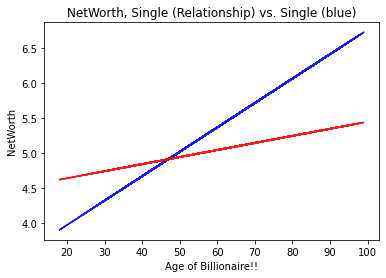

In [65]:
plt.plot(df["Age"], lm3.params[0] + lm3.params[1] * 1 + lm3.params[2] * df["Age"] + lm3.params[3] * 1 * df["Age"], 'b', label = 'America', alpha = 0.9)
plt.plot(df["Age"], lm3.params[0] + lm3.params[1] * 0 + lm3.params[2] * df["Age"] + lm3.params[3] * 0 * df["Age"], 'r', label = 'China', alpha = 0.9)
plt.title("NetWorth, Single (Relationship) vs. Single (blue)")
plt.xlabel("Age of Billionaire!!")
plt.ylabel("NetWorth")
plt.show()

In [57]:
print("Intercept..... b=", lm3.params[0])
print("C(relationship_or_single)[T.Single]..... b=", lm3.params[1])
print("Age..... b=", lm3.params[2])
print("interaction..... b=", lm3.params[3])

Intercept..... b= 4.441038483025078
C(relationship_or_single)[T.Single]..... b= -1.1607941296230246
Age..... b= 0.010069931591618926
interaction..... b= 0.024710191336097927
